# Five machine learning models for heart failure

Code is from [here](https://www.kaggle.com/code/tanmay111999/heart-failure-prediction-cv-score-90-5-models/notebook).

## Installations

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [ ]:
import pandas as pd
import numpy as np
import shap
import pickle

from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

## load dataset

In [ ]:
data = pd.read_csv('heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## Divide features in numerical and categorical

In [ ]:
col = list(data.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


## Encode categorical features

In [ ]:
le = LabelEncoder()
df1 = data.copy(deep = True)

df1['Sex'] = le.fit_transform(df1['Sex'])
df1['ChestPainType'] = le.fit_transform(df1['ChestPainType'])
df1['RestingECG'] = le.fit_transform(df1['RestingECG'])
df1['ExerciseAngina'] = le.fit_transform(df1['ExerciseAngina'])
df1['ST_Slope'] = le.fit_transform(df1['ST_Slope'])

df1.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.00,2,0
1,49,0,2,160,180,0,1,156,0,1.00,1,1
2,37,1,1,130,283,0,2,98,0,0.00,2,0
3,48,0,0,138,214,0,1,108,1,1.50,1,1
4,54,1,2,150,195,0,1,122,0,0.00,2,0


## Scale data

In [ ]:
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

print('Min oldpeak', df1['Oldpeak'].min())
print('Max oldpeak', df1['Oldpeak'].max())

print('Mean Age', df1['Age'].mean())
print('Std Age', df1['Age'].std())

print('Mean Cholesterol', df1['Cholesterol'].mean())
print('Std Cholesterol', df1['Cholesterol'].std())

print('Mean MaxHR', df1['MaxHR'].mean())
print('Std MaxHR', df1['MaxHR'].std())

df1['Oldpeak'] = mms.fit_transform(df1[['Oldpeak']])
df1['Age'] = ss.fit_transform(df1[['Age']])
df1['RestingBP'] = ss.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = ss.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] = ss.fit_transform(df1[['MaxHR']])

df1.head()

Min oldpeak -2.6
Max oldpeak 6.2
Mean Age 53.510893246187365
Std Age 9.43261650673201
Mean Cholesterol 198.7995642701525
Std Cholesterol 109.38414455220348
Mean MaxHR 136.80936819172112
Std MaxHR 25.4603341382503


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.43,1,1,0.41,0.83,0,1,1.38,0,0.30,2,0
1,-0.48,0,2,1.49,-0.17,0,1,0.75,0,0.41,1,1
2,-1.75,1,1,-0.13,0.77,0,2,-1.53,0,0.30,2,0
3,-0.58,0,0,0.30,0.14,0,1,-1.13,1,0.47,1,1
4,0.05,1,2,0.95,-0.03,0,1,-0.58,0,0.30,2,0


## Split data

In [ ]:
features = df1[df1.columns.drop(['HeartDisease','RestingBP','RestingECG'])].values
print(df1[df1.columns.drop(['HeartDisease','RestingBP','RestingECG'])].head())
target = df1['HeartDisease'].values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 2)

    Age  Sex  ChestPainType  Cholesterol  FastingBS  MaxHR  ExerciseAngina  \
0 -1.43    1              1         0.83          0   1.38               0   
1 -0.48    0              2        -0.17          0   0.75               0   
2 -1.75    1              1         0.77          0  -1.53               0   
3 -0.58    0              0         0.14          0  -1.13               1   
4  0.05    1              2        -0.03          0  -0.58               0   

   Oldpeak  ST_Slope  
0     0.30         2  
1     0.41         1  
2     0.30         2  
3     0.47         1  
4     0.30         2  


## Build model

In [ ]:
def model(classifier):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Accuracy : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    # plot_roc_curve(classifier, x_test,y_test)
    # plt.title('ROC_AUC_Plot')
    # plt.show()

## Evaluate model

In [ ]:
colors = ['#F93822','#FDD20E']

In [ ]:
def model_evaluation(classifier):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = colors,fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

## Logistic Regression

In [ ]:
classifier_lr = LogisticRegression(random_state = 0,C=10,penalty= 'l2') 
model(classifier_lr)

Accuracy :  87.50%
Cross Validation Score :  91.12%
ROC_AUC Score :  87.43%


              precision    recall  f1-score   support

           0       0.88      0.85      0.87        89
           1       0.87      0.89      0.88        95

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



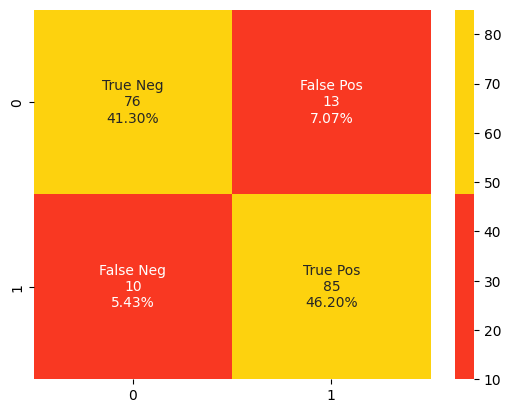

In [ ]:
model_evaluation(classifier_lr)

## Support Vector Classifier

In [ ]:
classifier_svc = SVC(kernel = 'linear', C = 0.1, probability=True)
model(classifier_svc)

Accuracy :  87.50%
Cross Validation Score :  90.53%
ROC_AUC Score :  87.43%


              precision    recall  f1-score   support

           0       0.88      0.85      0.87        89
           1       0.87      0.89      0.88        95

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



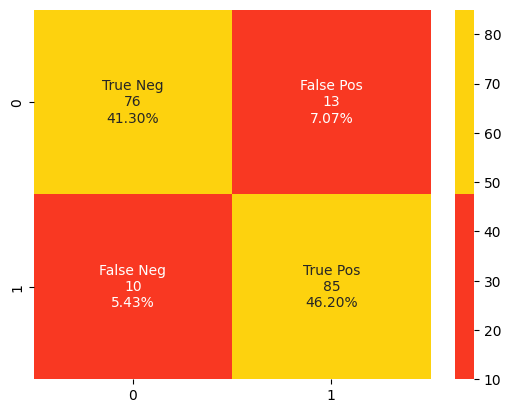

In [ ]:
model_evaluation(classifier_svc)

## Decision Tree Classifier

In [ ]:
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)
model(classifier_dt)

Accuracy :  84.78%
Cross Validation Score :  89.09%
ROC_AUC Score :  84.62%


              precision    recall  f1-score   support

           0       0.88      0.80      0.84        89
           1       0.83      0.89      0.86        95

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



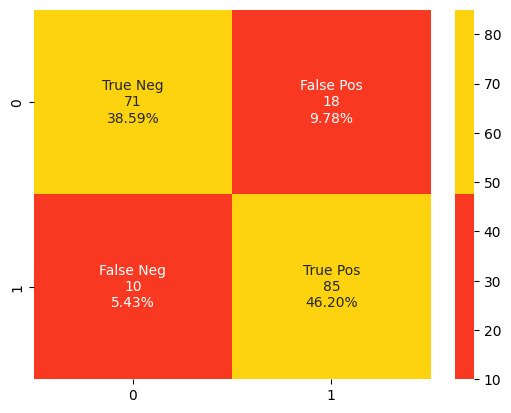

In [ ]:
model_evaluation(classifier_dt)

## Random Forest Classifier

In [ ]:
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)
model(classifier_rf)

Accuracy :  84.24%
Cross Validation Score :  92.91%
ROC_AUC Score :  84.06%


              precision    recall  f1-score   support

           0       0.88      0.79      0.83        89
           1       0.82      0.89      0.85        95

    accuracy                           0.84       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.84      0.84       184



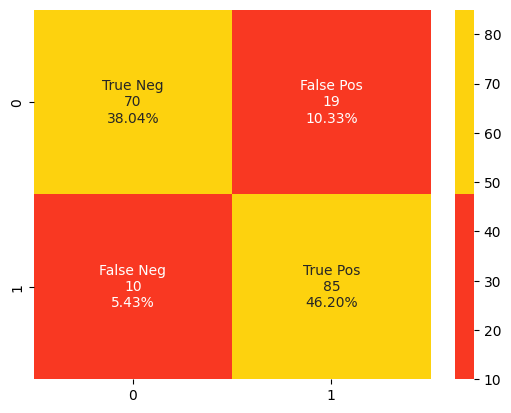

In [ ]:
model_evaluation(classifier_rf)

## K-nearest Neighbors Classifier

In [ ]:
classifier_knn = KNeighborsClassifier(leaf_size = 1, n_neighbors = 3,p = 1)
model(classifier_knn)

Accuracy :  81.52%
Cross Validation Score :  89.34%
ROC_AUC Score :  81.36%


              precision    recall  f1-score   support

           0       0.84      0.76      0.80        89
           1       0.80      0.86      0.83        95

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.81       184



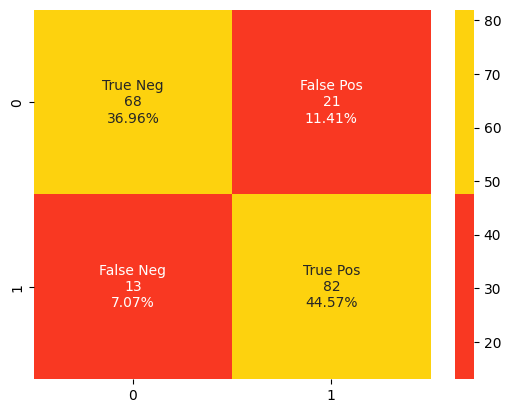

In [ ]:
model_evaluation(classifier_knn)

## Shap values & feature importances

In [ ]:
# Data before train/test split
X = df1[df1.columns.drop(['HeartDisease', 'RestingBP','RestingECG'])]
# Training data in df
X_train_shap = pd.DataFrame(x_train, columns= X.columns)
# Names of the features
feature_names = X_train_shap.columns

### LR classifier

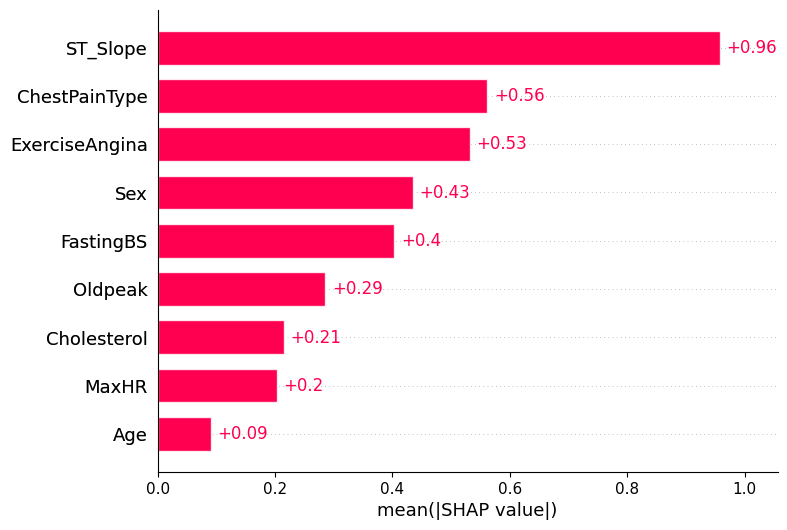

In [ ]:
expl_lr = shap.Explainer(classifier_lr, X_train_shap)
shap_val_lr = expl_lr(X_train_shap)
shap.plots.bar(shap_val_lr)
# shap.summary_plot(shap_val_lr, plot_type='bar')

In [ ]:
pickle.dump(expl_lr,open("expl_lr.pkl","wb"))

In [ ]:
pickle.dump(shap_val_lr,open("shap_val_lr.pkl","wb"))

### SVC classfier

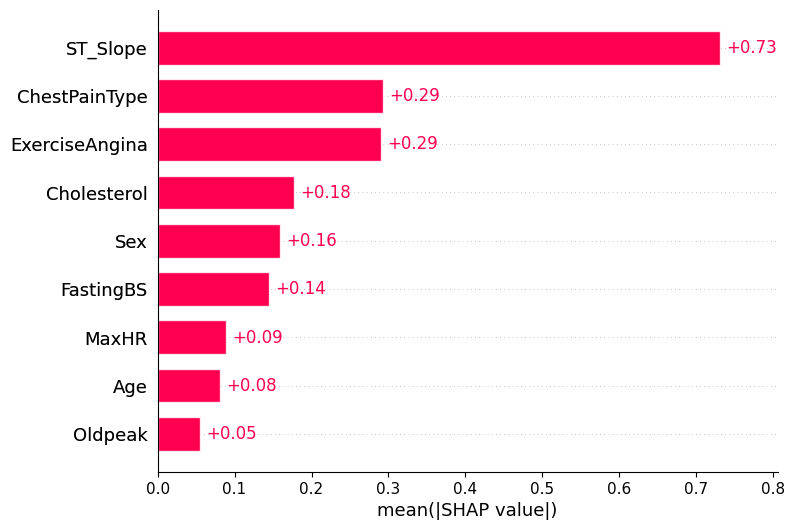

In [ ]:
expl_svc = shap.Explainer(classifier_svc, X_train_shap)
shap_val_svc = expl_svc(X_train_shap)
shap.plots.bar(shap_val_svc)
# shap.summary_plot(shap_val_svc, plot_type='bar')

In [ ]:
pickle.dump(expl_svc,open("expl_svc.pkl","wb"))

In [ ]:
pickle.dump(shap_val_svc,open("shap_val_svc.pkl","wb"))

### DT classifier

[0.         0.01060272 0.01553925 0.02633637 0.04434161 0.0462521
 0.07638391 0.11473639 0.66580765]


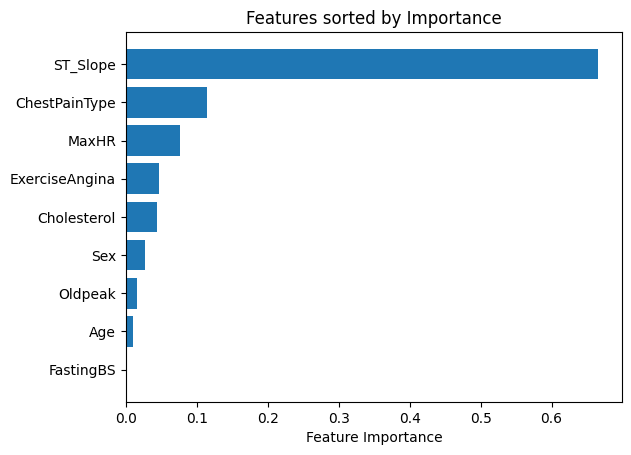

In [ ]:
# Calculate the Importance of the features
feature_importance_dt = np.zeros(len(feature_names))
feature_importance_dt = np.add(feature_importance_dt, classifier_dt.feature_importances_)

# Sort the features on Importance
index_sorted_dt = feature_importance_dt.argsort()
print(feature_importance_dt[index_sorted_dt])

# Plot the Importance of the features
plt.barh(feature_names[index_sorted_dt], feature_importance_dt[index_sorted_dt])
plt.xlabel("Feature Importance")
plt.title("Features sorted by Importance")
plt.show()

### RF classifier

[0.01768432 0.03165429 0.03178888 0.07301327 0.07540991 0.08911294
 0.14778593 0.17670843 0.35684204]


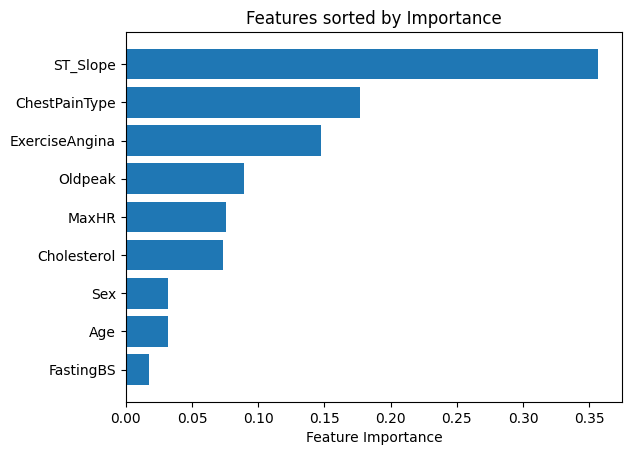

In [ ]:
# Calculate the Importance of the features
feature_importance_rf = np.zeros(len(feature_names))
feature_importance_rf = np.add(feature_importance_rf, classifier_rf.feature_importances_)

# Sort the features on Importance
index_sorted_rf = feature_importance_rf.argsort()
print(feature_importance_rf[index_sorted_rf])

# Plot the Importance of the features
plt.barh(feature_names[index_sorted_rf], feature_importance_rf[index_sorted_rf])
plt.xlabel("Feature Importance")
plt.title("Features sorted by Importance")
plt.show()

### KNN classifier

In [ ]:
# not given

TypeError: ignored

## Download best models

In [ ]:
pickle.dump(classifier_lr,open("lr_heart.pkl","wb"))

In [ ]:
pickle.dump(classifier_svc,open("svc_heart.pkl","wb"))

In [ ]:
pickle.dump(classifier_dt,open("dt_heart.pkl","wb"))

In [ ]:
pickle.dump(classifier_rf,open("rf_heart.pkl","wb"))

In [ ]:
pickle.dump(classifier_knn,open("knn_heart.pkl","wb"))